In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, GridSearchCV
import pyspark


In [2]:
TARGET_COLUMN = 'category'
TEXT_COLUMN = 'review'

def read_set(set_name='train', category='pos'):
    review_path = os.path.join('data', set_name, category)

    def read_review(file_name):
        review_id, review_rating = file_name.split('.')[0].split('_')
        file_path = os.path.join(review_path, file_name)
        with open(file_path) as f:
            review = f.read()
        return {
            TARGET_COLUMN: category,
            'review_id': int(review_id),
            'review_rating': int(review_rating),
            TEXT_COLUMN: review}

    return pd.DataFrame([read_review(file_name) for file_name in os.listdir(review_path)])

In [3]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

def get_data():
    positiv_train = read_set(set_name='train', category='pos')
    positiv_test = read_set(set_name='test', category='pos')

    negative_train = read_set(set_name='train', category='neg')
    negative_test = read_set(set_name='test', category='neg')

    train = shuffle(pd.concat([positiv_train, negative_train], ignore_index=True))
    test = shuffle(pd.concat([positiv_test, negative_test], ignore_index=True))
    train[TARGET_COLUMN] = LabelEncoder().fit_transform(train[TARGET_COLUMN])
    test[TARGET_COLUMN] = LabelEncoder().fit_transform(test[TARGET_COLUMN])
    return train, test  

In [4]:
train, test = get_data()

In [5]:
train.shape, test.shape

((25000, 4), (25000, 4))

In [6]:
train.head()

,category,review,review_id,review_rating
14413,0,This movie fails miserably on every level. I h...,8649,1
14943,0,You know those films that have you trapped in ...,11953,1
21132,0,THE SEVENTH SIGN has a great opening hook as t...,7943,4
3177,1,When I started to watch this movie on VH-1 I c...,7501,8
16627,0,I had some time to kill before watching footba...,3129,1


In [7]:
train.to_parquet('train.parquet', compression='UNCOMPRESSED')

In [8]:
test.to_parquet('test.parquet', compression='UNCOMPRESSED')

# Text preprocessing

## Drop duplicates

In [9]:
def drop_duplicate_values(x):
    return x.drop_duplicates()

In [10]:
train = FunctionTransformer(drop_duplicate_values, validate=False).transform(train)
test = FunctionTransformer(drop_duplicate_values, validate=False).transform(test)

In [11]:
train.shape, test.shape

((25000, 4), (25000, 4))

## Text Based Features

In [12]:
from textblob import TextBlob

USE_TEXT_BLOB = True

def get_text_blob(text):
    text_blob = TextBlob(str(text))
    return {
        'polarity': text_blob.polarity,
        'subjectivity': text_blob.subjectivity,
    }

Sentiment analysis is basically the process of determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.

> The sentiment function of textblob returns two properties, **polarity**, and **subjectivity**.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

##### But where do these numbers come from?

[PatternAnalyzer Class](https://github.com/sloria/TextBlob/blob/0ffa8e07564982a514047de593ba3d8307d2ae85/textblob/en/sentiments.py#L17) provides the results from [here](https://github.com/sloria/TextBlob/blob/0ffa8e07564982a514047de593ba3d8307d2ae85/textblob/_text.py#L854)

The answer is in the [source code](https://github.com/sloria/TextBlob/blob/e883b03a61537b007e65cc3f12d716f7bfb10ef6/textblob/_text.py#L661)

The lexicon it refers to is in en-sentiment.xml, an [XML document](https://github.com/sloria/TextBlob/blob/e883b03a61537b007e65cc3f12d716f7bfb10ef6/textblob/en/en-sentiment.xml)

When calculating sentiment for a single word “averaging” technique is used.

```
TextBlob("great").sentiment
## Sentiment(polarity=0.8, subjectivity=0.75)
```
TextBlob doesn't not handle negation, and that ain't nothing!
```
TextBlob("not great").sentiment
## Sentiment(polarity=-0.4, subjectivity=0.75)
```
Negation multiplies the polarity by -0.5, and doesn't affect subjectivity.

TextBlob also handles modifier words! Here's the summarized record for “very” from the lexicon:
```
word   polarity  subjectivity  intensity
very        0.2           0.3        1.3
```
Recognizing “very” as a modifier word, TextBlob will ignore polarity and subjectivity and just use intensity to modify the following word:
```
TextBlob("very great").sentiment
## Sentiment(polarity=1.0, subjectivity=0.9750000000000001)
```
The polarity gets maxed out at 1.0, but you can see that subjectivity is also modified by “very” to become 
0.75 ⋅ 1.3 = 0.975

Negation combines with modifiers in an interesting way: in addition to multiplying by -0.5 for the polarity, the inverse intensity of the modifier enters for both polarity and subjectivity.
```
TextBlob("not very great").sentiment
## Sentiment(polarity=-0.3076923076923077, subjectivity=0.5769230769230769)
```
___
TextBlob will ignore one-letter words in its sentiment phrases, which means things like this will work just the same way:
```
TextBlob("not a very great").sentiment
## Sentiment(polarity=-0.3076923076923077, subjectivity=0.5769230769230769)
```
And TextBlob will ignore words it doesn't know anything about:
```python
TextBlob("not a very great calculation").sentiment
## Sentiment(polarity=-0.3076923076923077, subjectivity=0.5769230769230769)
```

___
TextBlob goes along finding words and phrases it can assign polarity and subjectivity to, and it averages them all together for longer text.

In [13]:
# FEATURE_COLUMNS = ['review_rating', 'word_count', 'length', 'word_density']
FEATURE_COLUMNS = ['word_count', 'length', 'word_density']

> ```review_rating``` - the best performing feature. Every classification metric is 1.0 when ```review_rating``` is included. I have removed it for sporting sense.

In [14]:
def text_feature_selector(x):
    x['word_count'] = x[TEXT_COLUMN].apply(lambda text : len(str(text).split()))
    x['length'] = x[TEXT_COLUMN].apply(len)
    x['word_density'] = x['length'] / x['word_count']
    if USE_TEXT_BLOB:
        global FEATURE_COLUMNS
        FEATURE_COLUMNS += ['polarity', 'subjectivity']
        x['text_blob'] = x[TEXT_COLUMN].apply(get_text_blob)
        return pd.concat([x.drop('text_blob', axis=1), x['text_blob'].apply(pd.Series)], axis=1)
    return x

In [15]:
train = FunctionTransformer(text_feature_selector, validate=False).transform(train)
test = FunctionTransformer(text_feature_selector, validate=False).transform(test)

In [16]:
train.head()

,category,review,review_id,review_rating,word_count,length,word_density,polarity,subjectivity
14413,0,This movie fails miserably on every level. I h...,8649,1,134,671,5.007463,-0.247619,0.487500
14943,0,You know those films that have you trapped in ...,11953,1,192,1030,5.364583,-0.000869,0.582832
21132,0,THE SEVENTH SIGN has a great opening hook as t...,7943,4,107,564,5.271028,0.083995,0.541138
3177,1,When I started to watch this movie on VH-1 I c...,7501,8,57,271,4.754386,0.300000,0.573333
16627,0,I had some time to kill before watching footba...,3129,1,379,2050,5.408971,0.009024,0.431810


## Removing Stopwords & Lemmatization

**Stemming** and **Lemmatization** are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

*"**Stemming** is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language."*

**Stem (root) is the part of the word to which you add inflectional (changing/deriving) affixes such as (-ed,-ize, -s,-de,mis).** So stemming a word or sentence may result in words that are not actual words. Stems are created by removing the suffixes or prefixes used with a word.

*"**Lemmatization**, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words."*

For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words. Because lemmatization returns an actual word of the language, it is used where it is necessary to get valid words.

* Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word.

* Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used WordNet corpus and a corpus for stop words as well to produce lemma which makes it slower than stemming. You also had to define a parts-of-speech to obtain the correct lemma.

So when to use what! The above points show that if speed is focused then stemming should be used since lemmatizers scan a corpus which consumed time and processing. It depends on the application you are working on that decides if stemmers should be used or lemmatizers. If you are building a language application in which language is important you should use lemmatization as it uses a corpus to match root forms.

To summarize: lemmatization is used in this task.

In [17]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import tokenize

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def word_lemmatizer(word):
    word = word.replace('_', '')
    word1 = wordnet_lemmatizer.lemmatize(word, pos = "n") # NOUNS
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # VERB
    return wordnet_lemmatizer.lemmatize(word2, pos = ("a")) # ADJ
    

def text_lemmatizer(text):
    return ' '.join(map(word_lemmatizer, text))


def lemmatizer(x):
    x[TEXT_COLUMN] = x[TEXT_COLUMN].apply(lambda text: text_lemmatizer(tokenize(remove_stopwords(text))))
    return x

[nltk_data] Downloading package wordnet to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
train = FunctionTransformer(lemmatizer, validate=False).transform(train)
test = FunctionTransformer(lemmatizer, validate=False).transform(test)

While using gensim for removing stopwords, we can directly use it on the raw text. 
There’s no need to perform tokenization before removing stopwords.

However Gensim provide lemmatization facilities based on the `pattern` package.  Installation of `pattern` package is painfull therefore I have used nltk for lemmatization.

I had tried to use nltk only, however I was not satisfied with the result. Therefore a used gensim for tokenisation and stop-words removing and nltk for other activities.

Actually gensim tokenization is a [regexp](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/utils.py#L55), which select contiguous sequences of alphabetic characters (no digits!).

Stop words removing in gensim is a filtration by [this](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/parsing/preprocessing.py#L46) corpus of words.

In [19]:
train.head()

,category,review,review_id,review_rating,word_count,length,word_density,polarity,subjectivity
14413,0,This movie fail miserably level I idea let s i...,8649,1,134,671,5.007463,-0.247619,0.487500
14943,0,You know film trap cinema You re stick best se...,11953,1,192,1030,5.364583,-0.000869,0.582832
21132,0,THE SEVENTH SIGN great open hook Israeli defen...,7943,4,107,564,5.271028,0.083995,0.541138
3177,1,When I start watch movie VH I cringe The MTV m...,7501,8,57,271,4.754386,0.300000,0.573333
16627,0,I time kill watch football I saw movie offer s...,3129,1,379,2050,5.408971,0.009024,0.431810


## Bag of words / TF-IDF (N-grams)

In [20]:
x_train = train[TEXT_COLUMN].tolist()
y_train = train[TARGET_COLUMN].tolist()

x_test = test[TEXT_COLUMN].tolist()
y_test = test[TARGET_COLUMN].tolist()

A corpus of documents can be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

In Sklearn the general process of turning a collection of text documents into numerical feature vectors is called **vectorization**. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have many feature values that are zeros (typically more than 99% of them).

> In order to be able to store such a matrix in memory but also to speed up algebraic operations matrix / vector, implementations will typically use a sparse representation.


```CountVectorizer``` implements both tokenization and occurrence counting in a single class

Each term found by the analyzer during the fit is assigned a unique integer index corresponding to a column in the resulting matrix.

> The converse mapping from feature name to column index is stored in the vocabulary_ attribute of the vectorizer

> Words that were not seen in the training corpus will be completely ignored in future calls to the transform method

A collection of unigrams (what bag of words is) cannot capture phrases and multi-word expressions, effectively disregarding any word order dependence. Additionally, the bag of words model doesn’t account for potential misspellings or word derivations.

**N-grams to the rescue!** Instead of building a simple collection of unigrams (n=1), one might prefer a collection of bigrams (n=2), where occurrences of pairs of consecutive words are counted.

One might alternatively consider a collection of character n-grams, a representation resilient against misspellings and derivations.

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

Tf means **term-frequency** while tf–idf means term-frequency times **inverse document-frequency**

> This normalization is implemented by the ```TfidfTransformer``` class

In [21]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# count_vect = CountVectorizer(ngram_range=(2, 3))
# count_vect.fit(x_train)

# xtrain_count =  count_vect.transform(x_train)
# xtest_count =  count_vect.transform(x_test)

# tfidf_transformer = TfidfTransformer(smooth_idf=False)
# tfidf_transformer.fit(xtrain_count)

# xtrain_count =  tfidf_transformer.transform(xtrain_count)
# xtest_count =  tfidf_transformer.transform(xtest_count)
# xtrain_count

As **tf–idf** is very often used for text features, there is also another class called ```TfidfVectorizer``` that combines all the options of ```CountVectorizer``` and ```TfidfTransformer``` in a single model:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_count_vect = TfidfVectorizer(ngram_range=(2, 3))
tfidf_count_vect.fit(x_train)

tfidf_xtrain_count =  tfidf_count_vect.transform(x_train)
tfidf_xtest_count =  tfidf_count_vect.transform(x_test)
tfidf_xtrain_count

<25000x4304532 sparse matrix of type '<class 'numpy.float64'>'
	with 6063558 stored elements in Compressed Sparse Row format>

# Base Line

In [23]:
from sklearn import naive_bayes

classifier = naive_bayes.MultinomialNB()

classifier.fit(tfidf_xtrain_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
train_predictions = classifier.predict(tfidf_xtrain_count)
test_predictions = classifier.predict(tfidf_xtest_count)

In [25]:
from sklearn.metrics import roc_auc_score, make_scorer
roc_auc_score(test_predictions, y_test)

0.8487050996703562

Prepare text based features

In [26]:
from sklearn.preprocessing import StandardScaler
text_features_train = train[FEATURE_COLUMNS]
text_features_test = test[FEATURE_COLUMNS]

standart_scaler = StandardScaler()
standart_scaler.fit(text_features_train)

text_features_train = standart_scaler.transform(text_features_train)
text_features_test = standart_scaler.transform(text_features_test)

Stacking is a way to ensemble multiple classifications or regression model. The point of stacking is to explore a space of different models for the same problem. The idea is that you can attack a learning problem with different types of models which are capable to learn some part of the problem, but not the whole space of the problem. 

So I had used classifier based on word embeddings. And then added results to other text based features for the next, high level, classifier.

In [27]:
text_features_train = np.concatenate((train_predictions.reshape((len(train_predictions), 1)), text_features_train), axis=1)
text_features_test = np.concatenate((test_predictions.reshape((len(test_predictions), 1)), text_features_test), axis=1)

In [28]:
text_features_train

array([[ 0.        , -0.5743824 , -0.65203945, ..., -0.47045169,
        -2.16164558, -0.47045169],
       [ 0.        , -0.24053017, -0.29415376, ...,  0.55629478,
        -0.64120241,  0.55629478],
       [ 0.        , -0.72979637, -0.75870732, ...,  0.10723613,
        -0.11827977,  0.10723613],
       ...,
       [ 0.        , -1.01184394, -1.00494065, ..., -0.87433454,
        -0.40477482, -0.87433454],
       [ 0.        ,  1.45751134,  1.52916913, ...,  0.27697671,
        -2.05456054,  0.27697671],
       [ 0.        , -0.60891884, -0.64007669, ...,  0.2026864 ,
        -0.216495  ,  0.2026864 ]])

In [29]:
from sklearn.linear_model import LogisticRegression

final_classifier = LogisticRegression()
final_classifier.fit(text_features_train, y_train)

predict = final_classifier.predict(text_features_test)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
roc_auc_score(predict, y_test)

0.8487050996703562

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, final_classifier.predict(text_features_test)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85     12500
           1       0.90      0.77      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



I tryied differend combinations of features. 

* some useless text based features 
* add feautres from TextBlob (polarity, subjectivity)
* add stacking
* add both

As expected performance from useless text based features is not great (roughly 50%) therefore classifier does not work.
After adding features from TextBlob the performance has increased as well as after stacking adding.

However in case using both this approaches the performance does not change. Results in table below:

| Stacking | TextBlob | roc_auc_score    |
|:---------|:---------|:---------------- |
| False    | False    |0.524879150671637 |
| False    | True     |0.7688462776927029|
| True     | False    |0.8487050996703562|
| True     | True     |0.8487050996703562|


According these results, in my opinion it is reasonable to use only nested classifier in next improving steps.

In [32]:
def separate_target(df):
    return df.drop(columns=[TARGET_COLUMN]), df[TARGET_COLUMN].tolist()

def get_splited_data():
    train, test = get_data()
    x_train, y_train = separate_target(train)
    x_test, y_test = separate_target(test)
    return x_train, y_train, x_test, y_test

In [33]:
x_train, y_train, x_test, y_test = get_splited_data()

## Preprocessing CV

It is time to find optimal param set for tf-idf model. 
```python
GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=0, test_size=0.3, train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('duplicates',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=True,
                                                            func=<function drop_duplicate_values at 0x7f816d4407b8>,
                                                            inv_kw_args=None,
                                                            inverse_func=None,
                                                            kw_args=None,
                                                            pass_y='deprecated',...
                                                      class_prior=None,
                                                      fit_prior=True))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'tfidf__lowercase': [True, False],
                         'tfidf__max_df': [0.5, 1.0],
                         'tfidf__ngram_range': [(1, 2), (1, 3), (2, 3)],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__sublinear_tf': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(roc_auc_score), verbose=3)
```
The best performaing paramset are:
```python
{
    'tfidf__lowercase': False,
    'tfidf__max_df': 0.5,
    'tfidf__ngram_range': (1, 2),
    'tfidf__norm': 'l2',
    'tfidf__sublinear_tf': True
}
```
with the score 

** 0.8772797250142277 **

So we are able to create preprocessor with optimal parameters.

In [34]:
preprocessor = Pipeline(steps=[
    ('duplicates', FunctionTransformer(drop_duplicate_values, validate=False)),
    ('lemmatizer', FunctionTransformer(lemmatizer, validate=False)),
    ('selector', FunctionTransformer(lambda x: x[TEXT_COLUMN].tolist(), validate=False)),
    ('tfidf', TfidfVectorizer(lowercase=False, max_df=0.5, ngram_range=(1, 2), norm='l2', sublinear_tf=True)),
])

preprocessor.fit(x_train)

x_train = preprocessor.transform(x_train)
x_test = preprocessor.transform(x_test)

# model CV

## Notes about SVM

[Support vector machines (SVMs)](https://scikit-learn.org/stable/modules/svm.html#svm-classification) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

> The support vector machines in scikit-learn support both dense (numpy.ndarray and convertible to that by numpy.asarray) and sparse (any scipy.sparse) sample vectors as input. However, to use an SVM to make predictions for sparse data, it must have been fit on such data. For optimal performance, use C-ordered numpy.ndarray (dense) or scipy.sparse.csr_matrix (sparse) with dtype=float64.

### [C-Support Vector Classification.](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using sklearn.svm.LinearSVC or sklearn.linear_model.SGDClassifier instead, possibly after a sklearn.kernel_approximation.Nystroem transformer.

### [Linear classifiers (SVM, logistic regression, a.o.) with SGD training.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

> This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net).



In [35]:
model = Pipeline(steps=[('classifier', naive_bayes.MultinomialNB())])

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [37]:
import itertools

def model_parametrs_generator(param_sets):
    yield from map(lambda x: dict(zip(param_sets.keys(), x)), list(itertools.product(*param_sets.values())))


In [38]:
SVM_param_sets = {
    'gamma': ['scale', 'auto'], 
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'degree': [3, 5]
}
SVM_models = [SVC(max_iter=10000, tol=1e-6, **x) for x in model_parametrs_generator(SVM_param_sets)]

SGD_param_sets = {
    'loss': ['hinge', 'log', 'squared_hinge'], 
    'penalty': ['l2', 'elasticnet'], 
    'learning_rate': ['optimal', 'adaptive'], 
    'early_stopping': [True, False]
}
SGD_models = [SGDClassifier(max_iter=10000, tol=1e-6, eta0=1, **x) for x in model_parametrs_generator(SGD_param_sets)]

NB_param_sets = {
    'alpha': [1, 1.5, 2, 3, 4, 10, 20, 100], 
}
NB_models = [naive_bayes.MultinomialNB(**x) for x in model_parametrs_generator(NB_param_sets)]
models = SVM_models + SGD_models + NB_models

In [39]:
models

[SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=10000, probability=False, random_state=None, shrinking=True,
     tol=1e-06, verbose=False),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
     max_iter=10000, probability=False, random_state=None, shrinking=True,
     tol=1e-06, verbose=False),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
     max_iter=10000, probability=False, random_state=None, shrinking=True,
     tol=1e-06, verbose=False),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=10000, probability=False, random_state=None, shrinking=True,
     tol=1e-06, verbose=False),
 SVC(C=1.0, cache_size=200, clas

In [40]:
parameters = {'classifier': models}

modelcv = GridSearchCV(
    model, parameters, scoring=make_scorer(roc_auc_score), 
    cv=ShuffleSplit(n_splits=4, test_size=0.3, random_state=0), 
    verbose=3, n_jobs=-1
)

In [41]:
modelcv.fit(x_train, y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 80.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 215.7min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 216.8min finished
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=0, test_size=0.3, train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('classifier',
                                        MultinomialNB(alpha=1.0,
                                                      class_prior=None,
                                                      fit_prior=True))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'classifier': [SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decisi...
                                                      epsilon=0.1, eta0=1,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      lear

In [42]:
modelcv.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=10000, probability=False,
                     random_state=None, shrinking=True, tol=1e-06,
                     verbose=False))],
         verbose=False)

In [43]:
modelcv.best_score_

0.8983750302856487

In [44]:
final_model = modelcv.best_estimator_

# final pipeline

In [45]:
x_train, y_train, x_test, y_test = get_splited_data()

In [46]:
preprocessor.fit(x_train)

x_train = preprocessor.transform(x_train)
x_test = preprocessor.transform(x_test)

In [47]:
final_model.fit(x_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=10000, probability=False,
                     random_state=None, shrinking=True, tol=1e-06,
                     verbose=False))],
         verbose=False)

In [48]:
predictions = final_model.predict(x_test)
roc_auc_score(predictions, y_test)

0.8903622215778859

In [49]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [50]:
coeficientrs = final_model.steps[0][1].coef_.toarray()

In [51]:
len(coeficientrs[0])

1724825

In [52]:
len(preprocessor['tfidf'].vocabulary_)

1724825

In [53]:
words_importance = {k: abs(coeficientrs[0][v]) for k, v in preprocessor['tfidf'].vocabulary_.items()}

In [54]:
import operator
sorted(words_importance.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('bad', 8.215728197193947),
 ('awful', 5.0529602900061885),
 ('waste', 5.004914361581078),
 ('great', 4.955918662341306),
 ('bore', 4.955086883267302),
 ('excellent', 4.612209487379359),
 ('poor', 4.319593073857386),
 ('fail', 3.8560372880337996),
 ('dull', 3.8372078204928344),
 ('perfect', 3.7745103242127644)]

In [55]:
from PIL import Image
import matplotlib.pyplot as plt

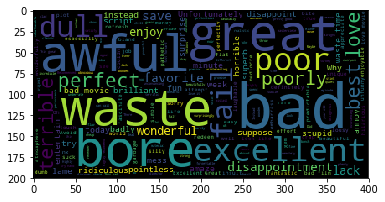

In [56]:
from wordcloud import WordCloud 
wc = WordCloud().generate_from_frequencies(words_importance)
plt.imshow(wc)

### Additional research.  Comparison with Spark

In [1]:
import pyspark
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import NGram
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel, LinearSVC

In [2]:
from itertools import chain
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *


def concat(type):
    def concat_(*args):
        return list(chain.from_iterable((arg if arg else [] for arg in args)))
    return udf(concat_, ArrayType(type))

In [3]:
session = pyspark.sql.SparkSession.Builder().getOrCreate()

In [4]:
train_sdf = session.read.parquet('train.parquet').select('category', 'review')
test_sdf = session.read.parquet('test.parquet').select('category', 'review')

In [5]:
tokenizer = Tokenizer(inputCol="review", outputCol="words")
train_wordsData = tokenizer.transform(train_sdf).drop('review')
test_wordsData = tokenizer.transform(test_sdf).drop('review')

In [6]:
# remover = StopWordsRemover(inputCol="words", outputCol="filtered")
# train_wordsData = remover.transform(train_wordsData).drop('words')
# test_wordsData = remover.transform(test_wordsData).drop('words')

In [7]:
ngram = NGram(n=2, inputCol="words", outputCol="ngrams2")
train_wordsData = ngram.transform(train_wordsData)
test_wordsData = ngram.transform(test_wordsData)

ngram = NGram(n=3, inputCol="words", outputCol="ngrams3")
train_wordsData = ngram.transform(train_wordsData)
test_wordsData = ngram.transform(test_wordsData)

In [8]:
concat_string_arrays = concat(StringType())
train_wordsData = train_wordsData.withColumn('concat', concat_string_arrays("ngrams2", "ngrams3")).drop('ngrams2', 'ngrams3')
test_wordsData = test_wordsData.withColumn('concat', concat_string_arrays("ngrams2", "ngrams3")).drop('ngrams2', 'ngrams3')

In [9]:
test_wordsData.limit(2).show()

+--------+--------------------+--------------------+
|category|               words|              concat|
+--------+--------------------+--------------------+
|       1|[this, is, defini...|[this is, is defi...|
|       1|[eisenstein, desc...|[eisenstein descr...|
+--------+--------------------+--------------------+



In [10]:
hashingTF = HashingTF(inputCol="concat", outputCol="rawFeatures", numFeatures=4194304)
train_featurizedData = hashingTF.transform(train_wordsData)
test_featurizedData = hashingTF.transform(test_wordsData)

In [11]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(train_featurizedData)
train_rescaledData = idfModel.transform(train_featurizedData)
test_rescaledData = idfModel.transform(test_featurizedData)

prepared_train = train_rescaledData.select("category", "features").withColumnRenamed("category", "label")
prepared_test = test_rescaledData.select("category", "features").withColumnRenamed("category", "label")

In [12]:
prepared_train.limit(2).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(4194304,[1495,26...|
|    0|(4194304,[20305,4...|
+-----+--------------------+



In [13]:
from sklearn.metrics import roc_auc_score, make_scorer

In [16]:
nb = NaiveBayes(smoothing=1.0)
model = nb.fit(prepared_train)
result = model.transform(prepared_test)
pd_resullt = result.select('label', 'prediction').toPandas()
roc_auc_score(pd_resullt['prediction'], pd_resullt['label'])

0.8008681920716808

In [17]:
nb = NaiveBayes(smoothing=2.0)
model = nb.fit(prepared_train)
result = model.transform(prepared_test)
pd_resullt = result.select('label', 'prediction').toPandas()
roc_auc_score(pd_resullt['prediction'], pd_resullt['label'])

0.8172002317223751

In [18]:
nb = NaiveBayes(smoothing=4.0)
model = nb.fit(prepared_train)
result = model.transform(prepared_test)
pd_resullt = result.select('label', 'prediction').toPandas()
roc_auc_score(pd_resullt['prediction'], pd_resullt['label'])

0.8342285060115242

In [14]:
nb = NaiveBayes(smoothing=10.0)
model = nb.fit(prepared_train)
result = model.transform(prepared_test)
pd_resullt = result.select('label', 'prediction').toPandas()
roc_auc_score(pd_resullt['prediction'], pd_resullt['label'])

0.8543450646941204

In [15]:
nb = NaiveBayes(smoothing=100.0)
model = nb.fit(prepared_train)
result = model.transform(prepared_test)
pd_resullt = result.select('label', 'prediction').toPandas()
roc_auc_score(pd_resullt['prediction'], pd_resullt['label'])

0.8735388512641297

Interesting. What abut Sklearn?

In [61]:
md = naive_bayes.MultinomialNB(alpha=1.0)
md.fit(x_train, y_train)
pred = md.predict(x_test)
roc_auc_score(pred, y_test)

0.8614320608505054

In [62]:
md = naive_bayes.MultinomialNB(alpha=10.0)
md.fit(x_train, y_train)
pred = md.predict(x_test)
roc_auc_score(pred, y_test)

0.8552201994797477

In [63]:
md = naive_bayes.MultinomialNB(alpha=20.0)
md.fit(x_train, y_train)
pred = md.predict(x_test)
roc_auc_score(pred, y_test)

0.8494364384809375

In [64]:
md = naive_bayes.MultinomialNB(alpha=100.0)
md.fit(x_train, y_train)
pred = md.predict(x_test)
roc_auc_score(pred, y_test)

0.8392917608403213